<a href="https://colab.research.google.com/github/pachterlab/JBMMCP_2023/blob/main/colab_f3_s2_s3_s4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
cat(system('python3 -c "from google.colab import drive\ndrive.mount()"', intern=TRUE), sep='\n', wait=TRUE)

Warning message in system("python3 -c \"from google.colab import drive\ndrive.mount()\"", :
“running command 'python3 -c "from google.colab import drive
drive.mount()"' had status 1”



TRUE


# Colab Setup

### Install packages from CRAN

In [2]:
install.packages("pals")
install.packages("patchwork")
install.packages("fastcluster")
install.packages("tictoc")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘dichromat’, ‘mapproj’, ‘maps’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



### Install Bioconductor pacakges

In [3]:
install.packages("BiocManager", repos = "http://cran.rstudio.com/")

if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("concordexR")
BiocManager::install("BiocNeighbors")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.17 (BiocManager 1.30.21), R 4.3.0 (2023-04-21)

Installing package(s) 'BiocVersion', 'concordexR'

also installing the dependencies ‘formatR’, ‘lambda.r’, ‘futile.options’, ‘matrixStats’, ‘futile.logger’, ‘snow’, ‘BH’, ‘BiocGenerics’, ‘MatrixGenerics’, ‘S4Vectors’, ‘IRanges’, ‘S4Arrays’, ‘BiocParallel’, ‘DelayedArray’, ‘pheatmap’


Old packages: 'bit', 'broom', 'bslib', 'curl', 'devtools', 'digest', 'gargle',
  'gert', 'googledrive', 'googlesheets4', 'highr', 'isoband', 'jsonlite',
  'pkgbuild', 'pkgload', 'roxygen2', 'testthat', 'tidyverse', 'usethis',
  'vctrs', 'whisker', 'boot', 'foreign'

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package 

### Clone GitHub Repo

In [4]:
system("git clone https://github.com/pachterlab/JBMMCP_2023.git")

### Load libraries

In [26]:
library(tictoc)
library(fs)
library(vroom)
library(stringr)
library(glue)
library(purrr)
library(tibble)
library(tidyr)
library(dplyr)
library(pals)

library(patchwork)
library(ggplot2)

library(fastcluster)
library(Matrix)

library(BiocNeighbors)
library(concordexR)

data_dir = path("./JBMMCP_2023/data")
print(data_dir)

./JBMMCP_2023/data


In [6]:
# Set color formatting
cluster_colors <- unname(alphabet()[1:20])
names(cluster_colors) <- paste0("cluster_",0:19)
cluster_order <- paste0("cluster_",0:19)


utero_labs = c("ExUt"= "Ex Utero", "InUt" = "In Utero")
batch_aes <- list(alpha=1,size=rel(2))
utero_colors <- c("ExUt" = "#4b4964ff", "InUt" = "#1b9e77ff")
utero_order <- c("ExUt", "InUt")

# Main Text Plots

##  Misc Plotting utilities

In [7]:
theme_concordex <- function(
        plot.type = c("heatmap", "point"),
        base_size = 12, base_family = "", base_line_size=base_size/24,
        base_rect_size = base_size/24){

    plot.type <- match.arg(plot.type)

    .theme_cdx_internal(plot.type, base_size=base_size, base_family=base_family,
                    base_line_size=base_line_size, base_rect_size=base_rect_size)

}

.theme_cdx_internal <- function(
        plot.type,
        base_size = 12, base_family = "", base_line_size=base_size/24,
        base_rect_size = base_size/24){

    half_line <- base_size/2
    .theme <- theme_bw(base_size=base_size, base_family=base_family,
                       base_line_size=base_line_size, base_rect_size=base_rect_size)

    if (plot.type %in% "heatmap"){
        panel.border <- element_rect(fill=NA, colour="black", linewidth=rel(2))

        axis.line <- element_blank()
        axis.text.x <- element_text(angle=90, hjust=0.9)
        axis.ticks <- element_blank()
        axis.title <- element_blank()

    } else {
        panel.border <- element_blank()

        axis.line <- element_line(colour="black", linewidth=0.5)
        axis.text.x <- .theme$axis.text.x
        axis.ticks <- element_line(colour= 'grey20', arrow=FALSE, inherit.blank=TRUE)
        axis.title <- NULL
    }

    .theme %+replace%
        theme(
            panel.border=panel.border,
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            plot.title = element_text(size=rel(0.8), hjust=0.5, margin=margin(0,0,half_line,0)),
            axis.line=axis.line,
            axis.text=element_text(size=rel(0.75), color="black"),
            axis.text.x = axis.text.x,
            axis.ticks=axis.ticks,
            axis.title=axis.title,
            legend.title=element_text(size=rel(0.85))
        )
}

plotManuscriptHeatmap <- function(data, mapping = aes(name, row), facet_layer = NULL){
  pl <- ggplot(data, mapping=mapping)

  pl <- pl +
    geom_tile(aes(fill=value),linewidth=0) +
    labs(fill = "Fraction of\nneighbors") +
    scale_fill_distiller(
      palette="YlGnBu",
      limits=c(0, 1.1),
      breaks=c(0,0.5,1),
      guide = guide_colorbar(frame.colour = "black",frame.linewidth=rel(0.55))
    ) +
    theme_concordex("heatmap")

  if (!is.null(facet_layer)) {
    pl <- pl + facet_layer + theme(strip.background = element_blank())
  }

  return(pl)
}

## Figure 3

### Generate UMAP Plots

The PCA and UMAP output are derived from the Colab notebook linked [here](https://github.com/pachterlab/CP_2023/blob/main/notebooks/uteroMixingAnalysis/uteroAnalysis_l2.ipynb). These results and figures are cited in the manuscript titled [Specious Art of Single Cell Genomics](https://doi.org/10.1101/2021.08.25.457696) (Chari, et.al.). The code cells below reproduce the UMAP figures from that paper.

In [12]:
coords_ss_umap <- vroom(path(data_dir, "umap-ss.csv"),
  show_col_types = FALSE, col_names = c('umap_ss_x','umap_ss_y'))

coords_log_umap <- vroom(path(data_dir, "umap-log.csv"),
  show_col_types = FALSE, col_names = c('umap_log_x','umap_log_y'))

pca_ss <- vroom(path(data_dir, "pca-ss.csv"),
  show_col_types = FALSE, col_names = FALSE)

pca_log <- vroom(path(data_dir, "pca-log.csv"),
  show_col_types = FALSE, col_names = FALSE)

meta <- vroom(path(data_dir, "utero-labels.csv"),
  show_col_types=FALSE, col_names=c("cluster","utero"), delim=",", )

meta$cluster <- paste0("cluster_", meta$cluster)

In [ ]:
head(meta)

cluster,utero
<chr>,<chr>
cluster_7,ExUt
cluster_5,ExUt
cluster_5,ExUt
cluster_3,ExUt
cluster_3,ExUt
cluster_2,ExUt


In [ ]:
# UMAP for log-normalized data, colored by cluster assignment
fig_log_clust_umap <- coords_log_umap %>%
    bind_cols(meta) %>%
    ggplot(aes(umap_log_x, umap_log_y, color=cluster)) +
    geom_point(alpha=0.2,size=1,shape=16) +
    guides(colour = guide_legend(override.aes = batch_aes)) +
    scale_color_manual(
        limits = names(cluster_colors),
        values = cluster_colors,
        labels = ~str_to_title(str_replace(., "_"," ")),
    ) +
    theme_bw() +
    theme(
        plot.background=element_blank(),
        panel.background=element_blank(),
        panel.grid=element_blank(),
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        aspect.ratio=1/1.15,
        legend.position = "right")

In [ ]:
# UMAP for log-normalized data, colored by growth condition
fig_log_utero_umap <- coords_log_umap %>%
    bind_cols(meta) %>%
    ggplot(aes(umap_log_x, umap_log_y, color=utero)) +
    geom_point(alpha=0.2,size=1,shape=16) +
    guides(colour = guide_legend(title="", override.aes = batch_aes)) +
    scale_color_manual(
        limits = names(utero_labs),
        values = utero_colors,
        labels = utero_labs) +
    theme_bw() +
    theme(
        plot.background=element_blank(),
        panel.background=element_blank(),
        panel.grid=element_blank(),
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        aspect.ratio=1/1.15,
        legend.position = "right")

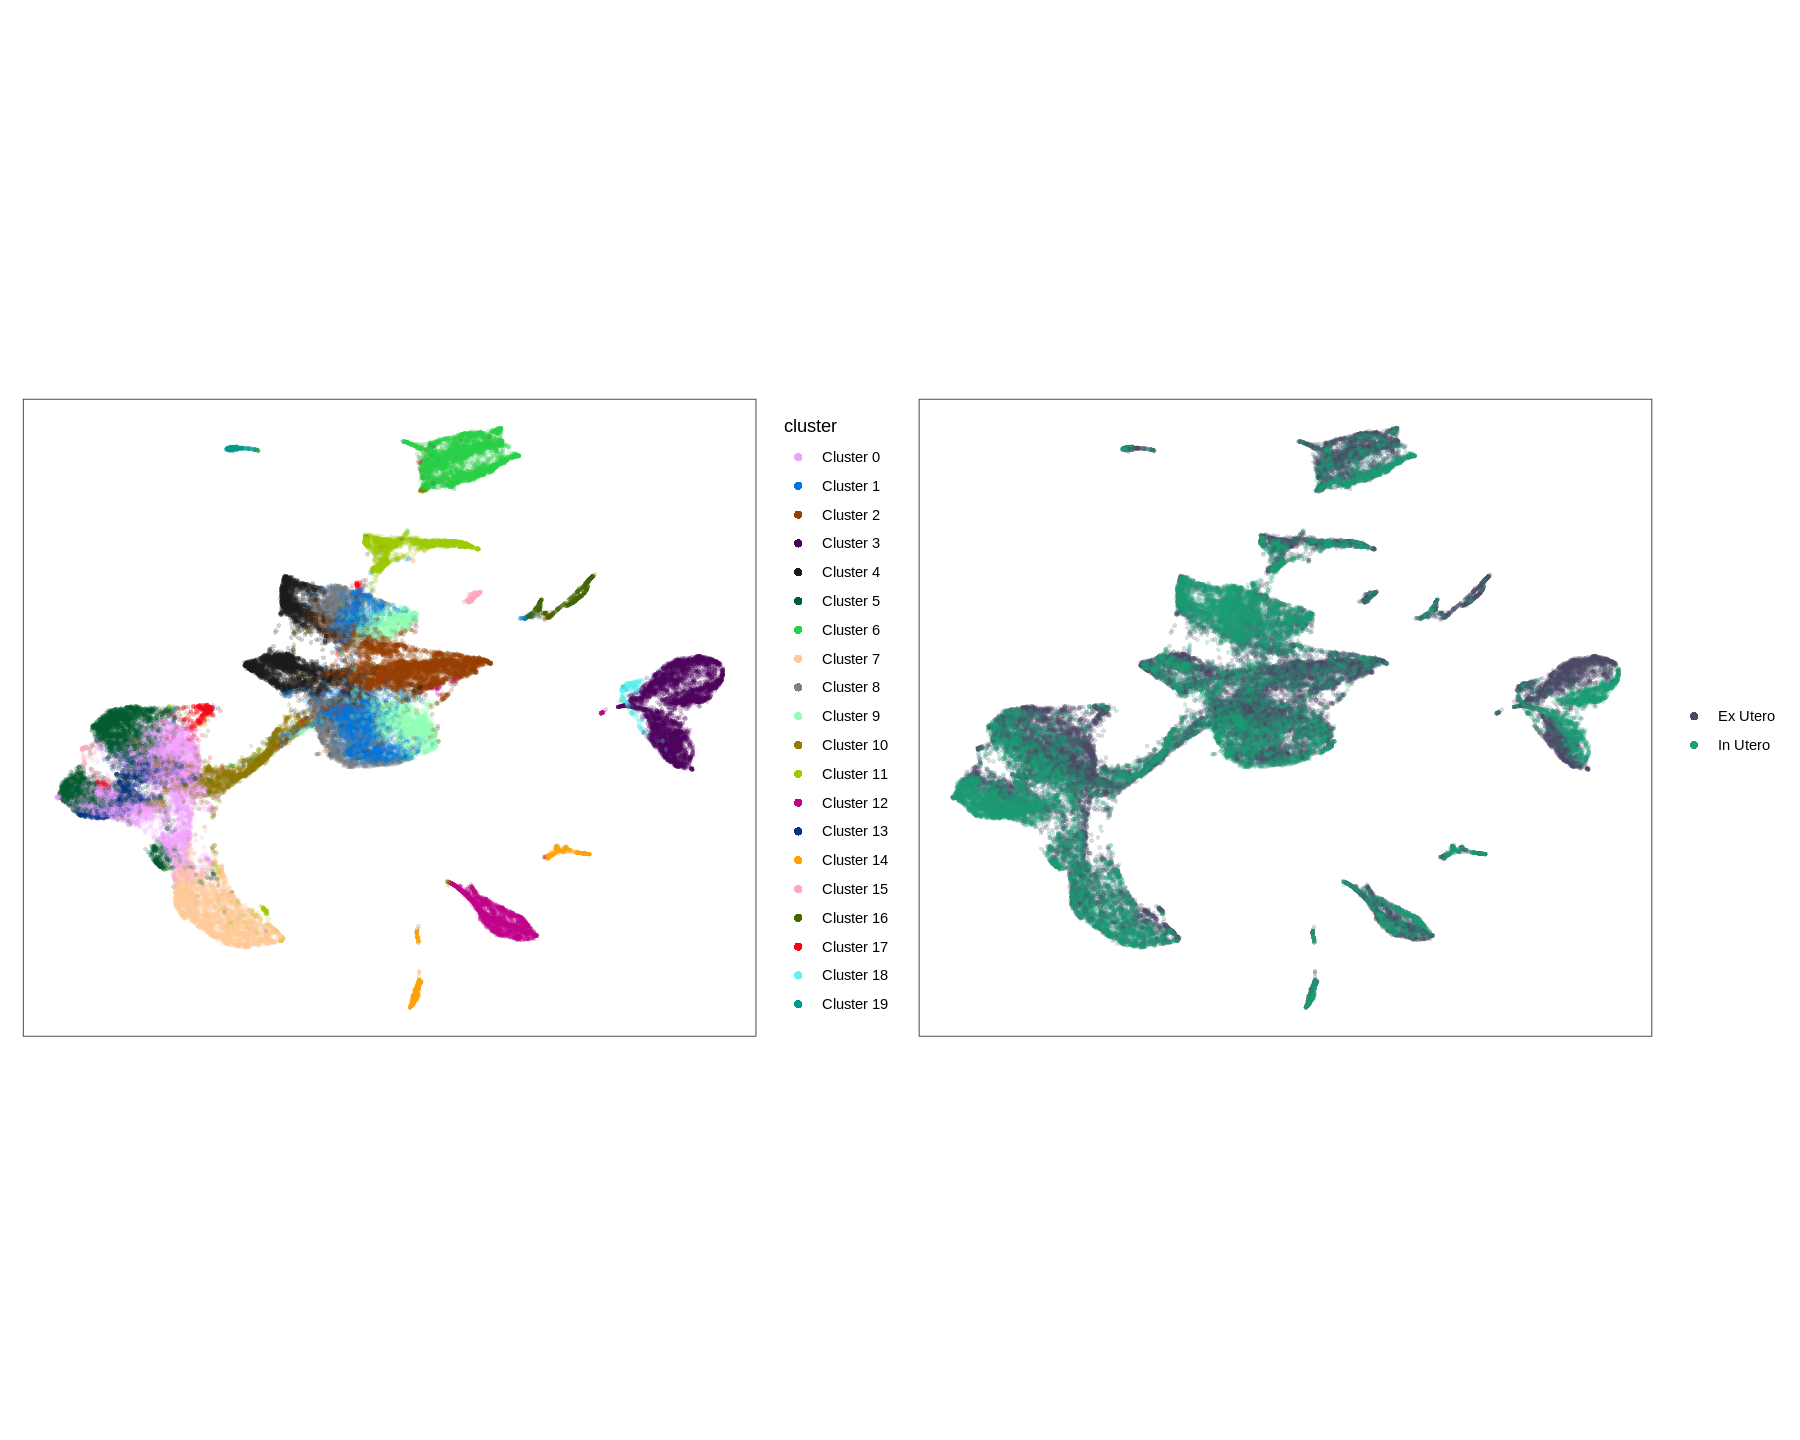

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)
fig_log_clust_umap | fig_log_utero_umap

In [ ]:
# UMAP for stabilized-scaled data, colored by cluster assignment
fig_ss_clust_umap <- coords_ss_umap %>%
    bind_cols(meta) %>%
    ggplot(aes(umap_ss_x, umap_ss_y, color=cluster)) +
    geom_point(alpha=0.2,size=1,shape=16) +
    guides(colour = guide_legend(override.aes = batch_aes)) +
    scale_color_manual(
        limits = names(cluster_colors),
        values = cluster_colors,
        labels = ~str_to_title(str_replace(., "_"," ")),
    ) +
    theme_bw() +
    theme(
        plot.background=element_blank(),
        panel.background=element_blank(),
        panel.grid=element_blank(),
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        aspect.ratio=1/1.15,
        legend.position = "right")

In [ ]:
# UMAP for log-normalized data, colored by growth condition
fig_ss_utero_umap <- coords_ss_umap %>%
    bind_cols(meta) %>%
    ggplot(aes(umap_ss_x, umap_ss_y, color=utero)) +
    geom_point(alpha=0.2,size=1,shape=16) +
    guides(colour = guide_legend(title="", override.aes = batch_aes)) +
    scale_color_manual(
        limits = names(utero_labs),
        values = utero_colors,
        labels = utero_labs) +
    theme_bw() +
    theme(
        plot.background=element_blank(),
        panel.background=element_blank(),
        panel.grid=element_blank(),
        axis.line = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        axis.title = element_blank(),
        aspect.ratio=1/1.15,
        legend.position = "right")

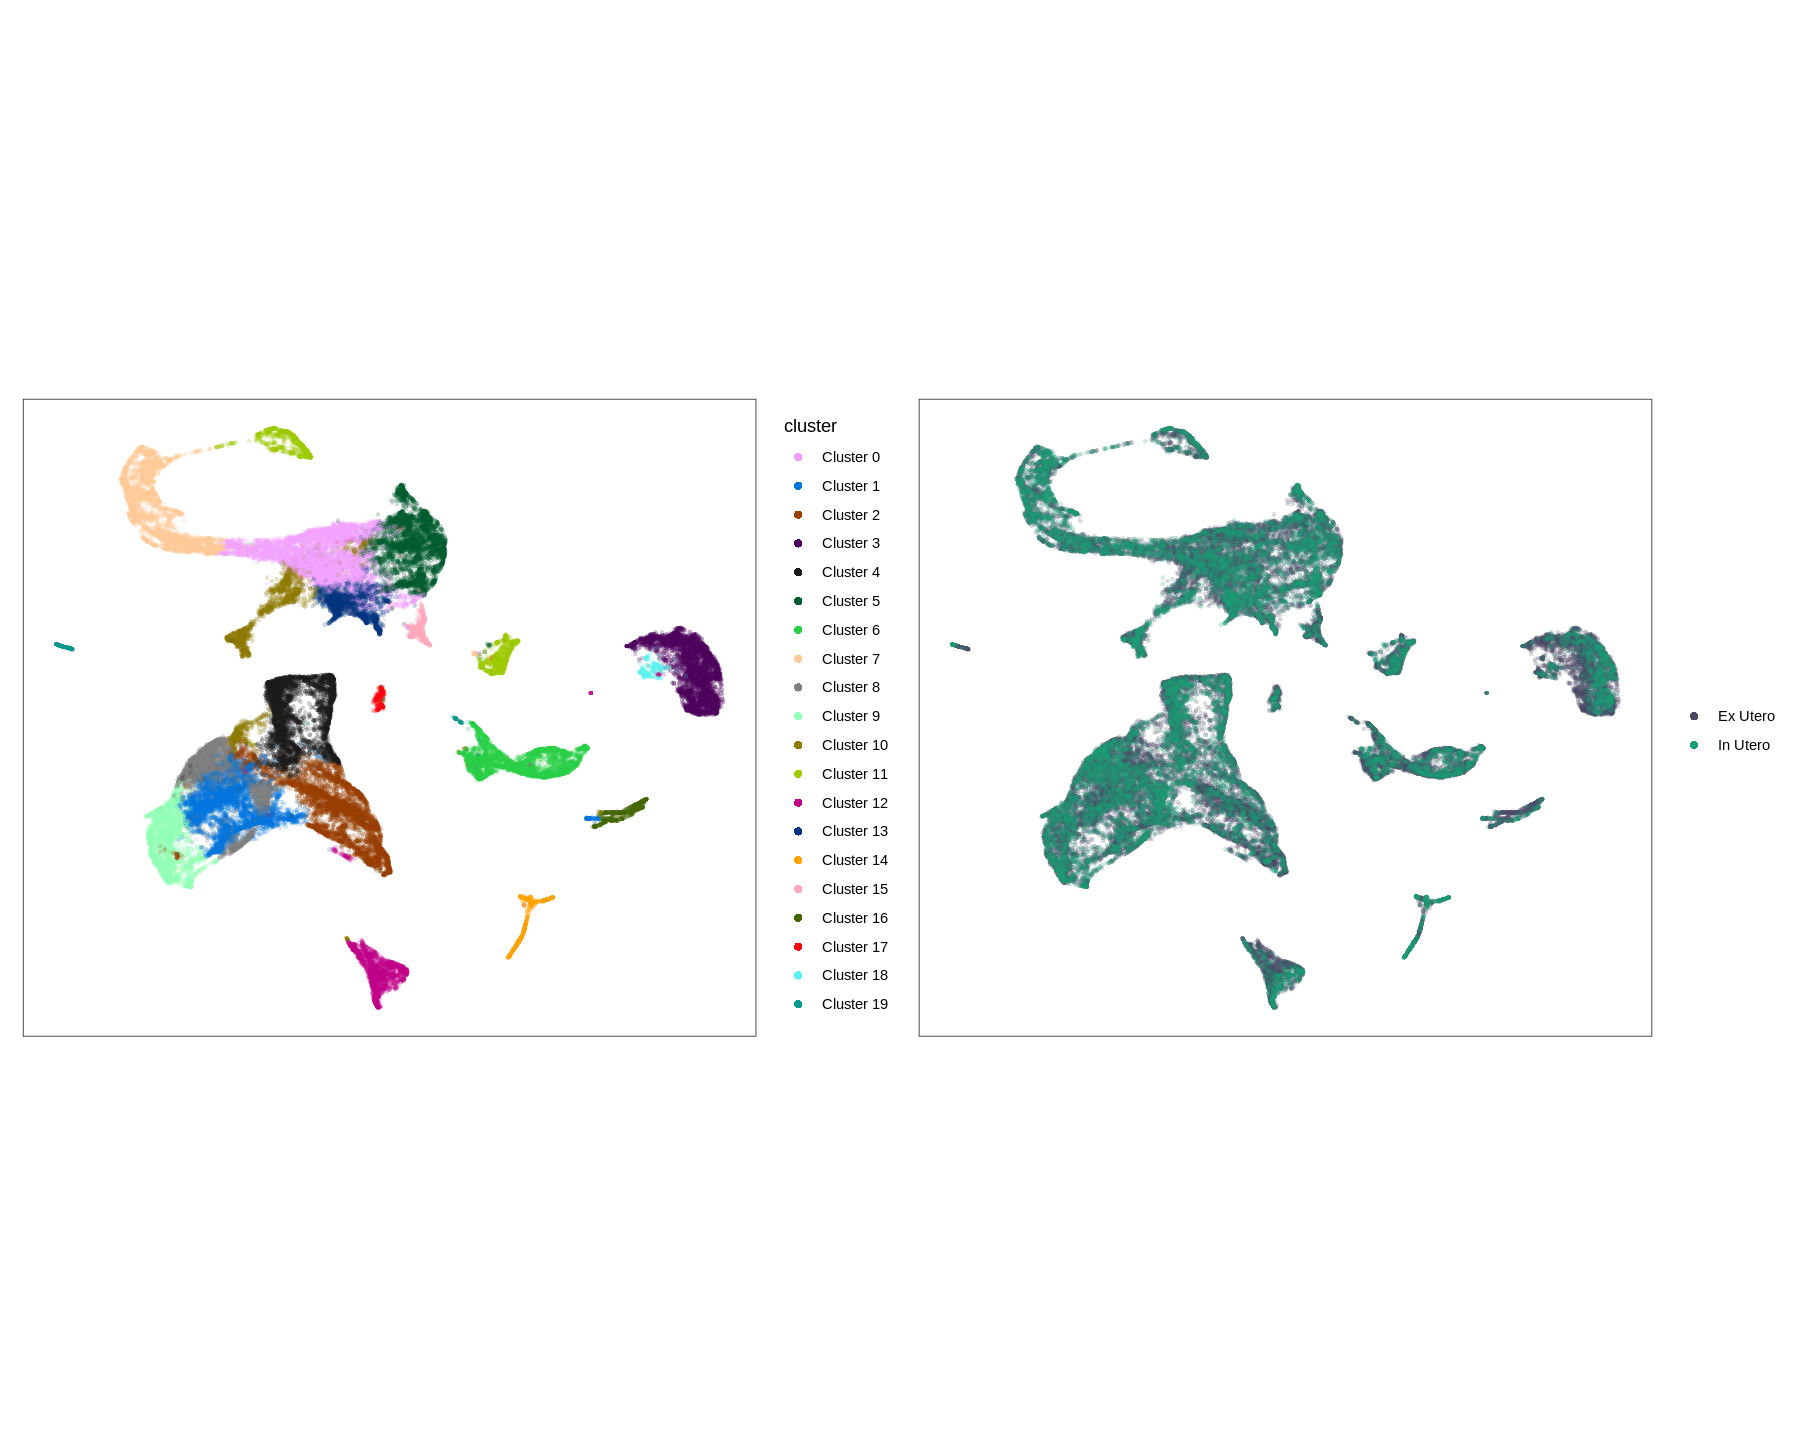

In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)

fig_ss_clust_umap | fig_ss_utero_umap

### Compute k-nearest neighbor graph

Use top 15 PCs to compute knn graph

In [ ]:
# stabilized, scaled
knn_ss_pca <- findKNN(as(pca_ss,'Matrix'), k=30, get.distance=FALSE)

#log normalized
knn_log_pca <- findKNN(as(pca_log,'Matrix'), k=30, get.distance=FALSE)

Use 2D UMAP coordinates to compute knn graph

In [ ]:
knn_ss_umap <- findKNN(as(coords_ss_umap[,c(1:2)],'Matrix'),
  k=30, get.distance=FALSE)


knn_log_umap <- findKNN(as(coords_log_umap[,c(1:2)],'Matrix'),
  k=30, get.distance=FALSE)

### Compute CONCORDEX

Use knn graphs from previous step to compute concordex (ratio). Here, we use cluster assignment and growth condition, but we note that concordex (ratio) can be computed usings any discrete label.  As above, we will perform the computation for the "Variance stabilized, scaled" and "Log normalized" data.

In [ ]:
# stabilized, scaled
cdx_clust_ss_pca  <- calculateConcordex(knn_ss_pca$index, meta$cluster, k=30)
cdx_clust_ss_umap <- calculateConcordex(knn_ss_umap$index, meta$cluster,k=30)

cdx_utero_ss_pca  <- calculateConcordex(knn_ss_pca$index, meta$utero, k=30)
cdx_utero_ss_umap <- calculateConcordex(knn_ss_umap$index, meta$utero,k=30)

# log-normalized
cdx_clust_log_pca  <- calculateConcordex(knn_log_pca$index, meta$cluster, k=30)
cdx_clust_log_umap <- calculateConcordex(knn_log_umap$index, meta$cluster,k=30)

cdx_utero_log_pca  <- calculateConcordex(knn_log_pca$index, meta$utero, k=30)
cdx_utero_log_umap <- calculateConcordex(knn_log_umap$index, meta$utero,k=30)

### Compute expanded similarity matrices and sort rows
Generate expanded similarity matrices and sort the rows using heirarchical clustering. Clustering/sorting the rows can take up to 15 minutes.

In [ ]:
#' Split a sparse Matrix into a list ot its columns
#' Returns a list of length `ncol(X)` containint the non-zero elements of the column
split.mtx.cols <- function(X, labels){

    X <- as(X, "CsparseMatrix")
    vals <- X@x
    # names(vals) <- labels[(X@i)+1]
    res<-split(vals, findInterval(seq_len(nnzero(X)), X@p, left.open=TRUE))

    names(res) <- labels

    res
}

concordex_map_sort <- function(x, labels){
  clust <- fastcluster::hclust.vector(x, method='single')
  row_order <- clust$order

  res <- as.matrix(x) %>%
        data.frame() %>%
        tibble::rownames_to_column(var='group') %>%
        mutate(
            group = str_remove(group, "\\.[0-9]+"),
            row_original = row_number()
        )
  res$row <- match(res$row_original, row_order)

  labels_uniq <- unique(labels)

  row_order_spl <- purrr::map(labels_uniq,
     \(key) {
        mx <- x[labels==key,]
        ord <- fastcluster::hclust.vector(mx, method='single')$order
        tibble(
          group=key, within_row_original=seq(dim(mx)[1]),
          within_row_order=match(seq(dim(mx)[1]),ord))
     })

  row_order_spl <- dplyr::bind_rows(row_order_spl)

  res <- res %>%
    group_by(group) %>%
    mutate(within_row_original=row_number()) %>% ungroup() %>%
    left_join(row_order_spl, by=c("group", "within_row_original"))


  res %>% pivot_longer(-c('group', contains('row')))
}

#' Compute the expanded similarity matrix
#' Expects index computed from BiocNeighbors::findkNN() and cell labels
concordex_map_full <- function(x, labels, k=30, cluster_rows=FALSE, ...){

    # Assume neighbors are oriented on the rows
    x.split <- split.mtx.cols(t(x), labels=labels)

    res <- map(x.split, \(x) {
      tbl <- c(table(labels[x])/k)
      data.frame(t(tbl))
    })

    names(res) <- labels

    res <- bind_rows(res, .id = "group")
    res <- replace(res, is.na(res),0)

    res <- Matrix(as.matrix(res[,-1]), dimnames = list(res$group, colnames(res)[-1]))

    if (cluster_rows) return(concordex_map_sort(as(res, "CsparseMatrix"), labels=labels))

    res <- as.matrix(res) %>%
        data.frame() %>%
        tibble::rownames_to_column(var='group') %>%
        mutate(
            group = str_remove(group, "\\.[0-9]+"),
            row_original = row_number()
        ) %>%
        pivot_longer(-c('group', contains('row')))

    res
}

In [ ]:
# Only need to sort the rows once

# tic("total time, cluster")
frac_clust_ss_pca <- concordex_map_full(knn_ss_pca$index, meta$cluster, k=30, cluster_rows=TRUE)
frac_clust_ss_umap <- concordex_map_full(knn_ss_umap$index, meta$cluster, k=30)

frac_utero_ss_pca <- concordex_map_full(knn_ss_pca$index, meta$utero, k=30, cluster_rows=TRUE)
frac_utero_ss_umap <- concordex_map_full(knn_ss_umap$index, meta$utero, k=30)
# toc()

In [ ]:
frac_clust_log_pca <- concordex_map_full(knn_log_pca$index, meta$cluster, k=30, cluster_rows=TRUE)
frac_clust_log_umap <- concordex_map_full(knn_log_umap$index, meta$cluster, k=30)

frac_utero_log_pca <- concordex_map_full(knn_log_pca$index, meta$utero, k=30, cluster_rows=TRUE)
frac_utero_log_umap <- concordex_map_full(knn_log_umap$index, meta$utero, k=30)

In [ ]:
# Add sort order to UMAP and join
frac_clust_ss_umap <- frac_clust_ss_pca %>%
  select(group, name, row_original, contains("within")) %>%
  right_join(frac_clust_ss_umap, by = join_by(group, row_original, name))

frac_clust_log_umap <- frac_clust_log_pca %>%
  select(group, name, row_original, contains("within")) %>%
  right_join(frac_clust_log_umap, by = join_by(group, row_original, name))


# Sort UMAP rows according to PCA
frac_utero_ss_umap <- frac_utero_ss_pca %>%
  select(group, name, row_original, contains("within")) %>%
  right_join(frac_utero_ss_umap, by = join_by(group, row_original, name))

frac_utero_log_umap <- frac_utero_log_pca %>%
  select(group, name, row_original, contains("within")) %>%
  right_join(frac_utero_log_umap, by = join_by(group, row_original, name))

In [ ]:
# now combine pca and umap frac into same object
frac_clust_ss <- bind_rows(
  list("PCA Space" = frac_clust_ss_pca, "UMAP Space" = frac_clust_ss_umap), .id = "id")

frac_clust_log <- bind_rows(
  list("PCA Space" = frac_clust_log_pca, "UMAP Space" = frac_clust_log_umap), .id = "id")

frac_utero_ss <- bind_rows(
  list("PCA Space" = frac_utero_ss_pca, "UMAP Space" = frac_utero_ss_umap), .id = "id")

frac_utero_log <- bind_rows(
  list("PCA Space" = frac_utero_log_pca, "UMAP Space" = frac_utero_log_umap), .id = "id")

### Growth Condition Plots

Plots for scaled, variance stabilized data faceted by growth conditon.

In [ ]:
cdx_map_utero_ss <- bind_rows("PCA Space" = data.frame(cdx_utero_ss_pca$map), "UMAP Space" = data.frame(cdx_utero_ss_umap$map), .id = 'id')
cdx_map_utero_ss <- cdx_map_utero_ss %>%
  tibble::rownames_to_column('row_label') %>%
  mutate(
  row_label = str_remove(row_label, "\\.+[0-9]+"),
  row_label = factor(row_label, c("InUt", "ExUt"))) %>%
  pivot_longer(-c("row_label", "id"))

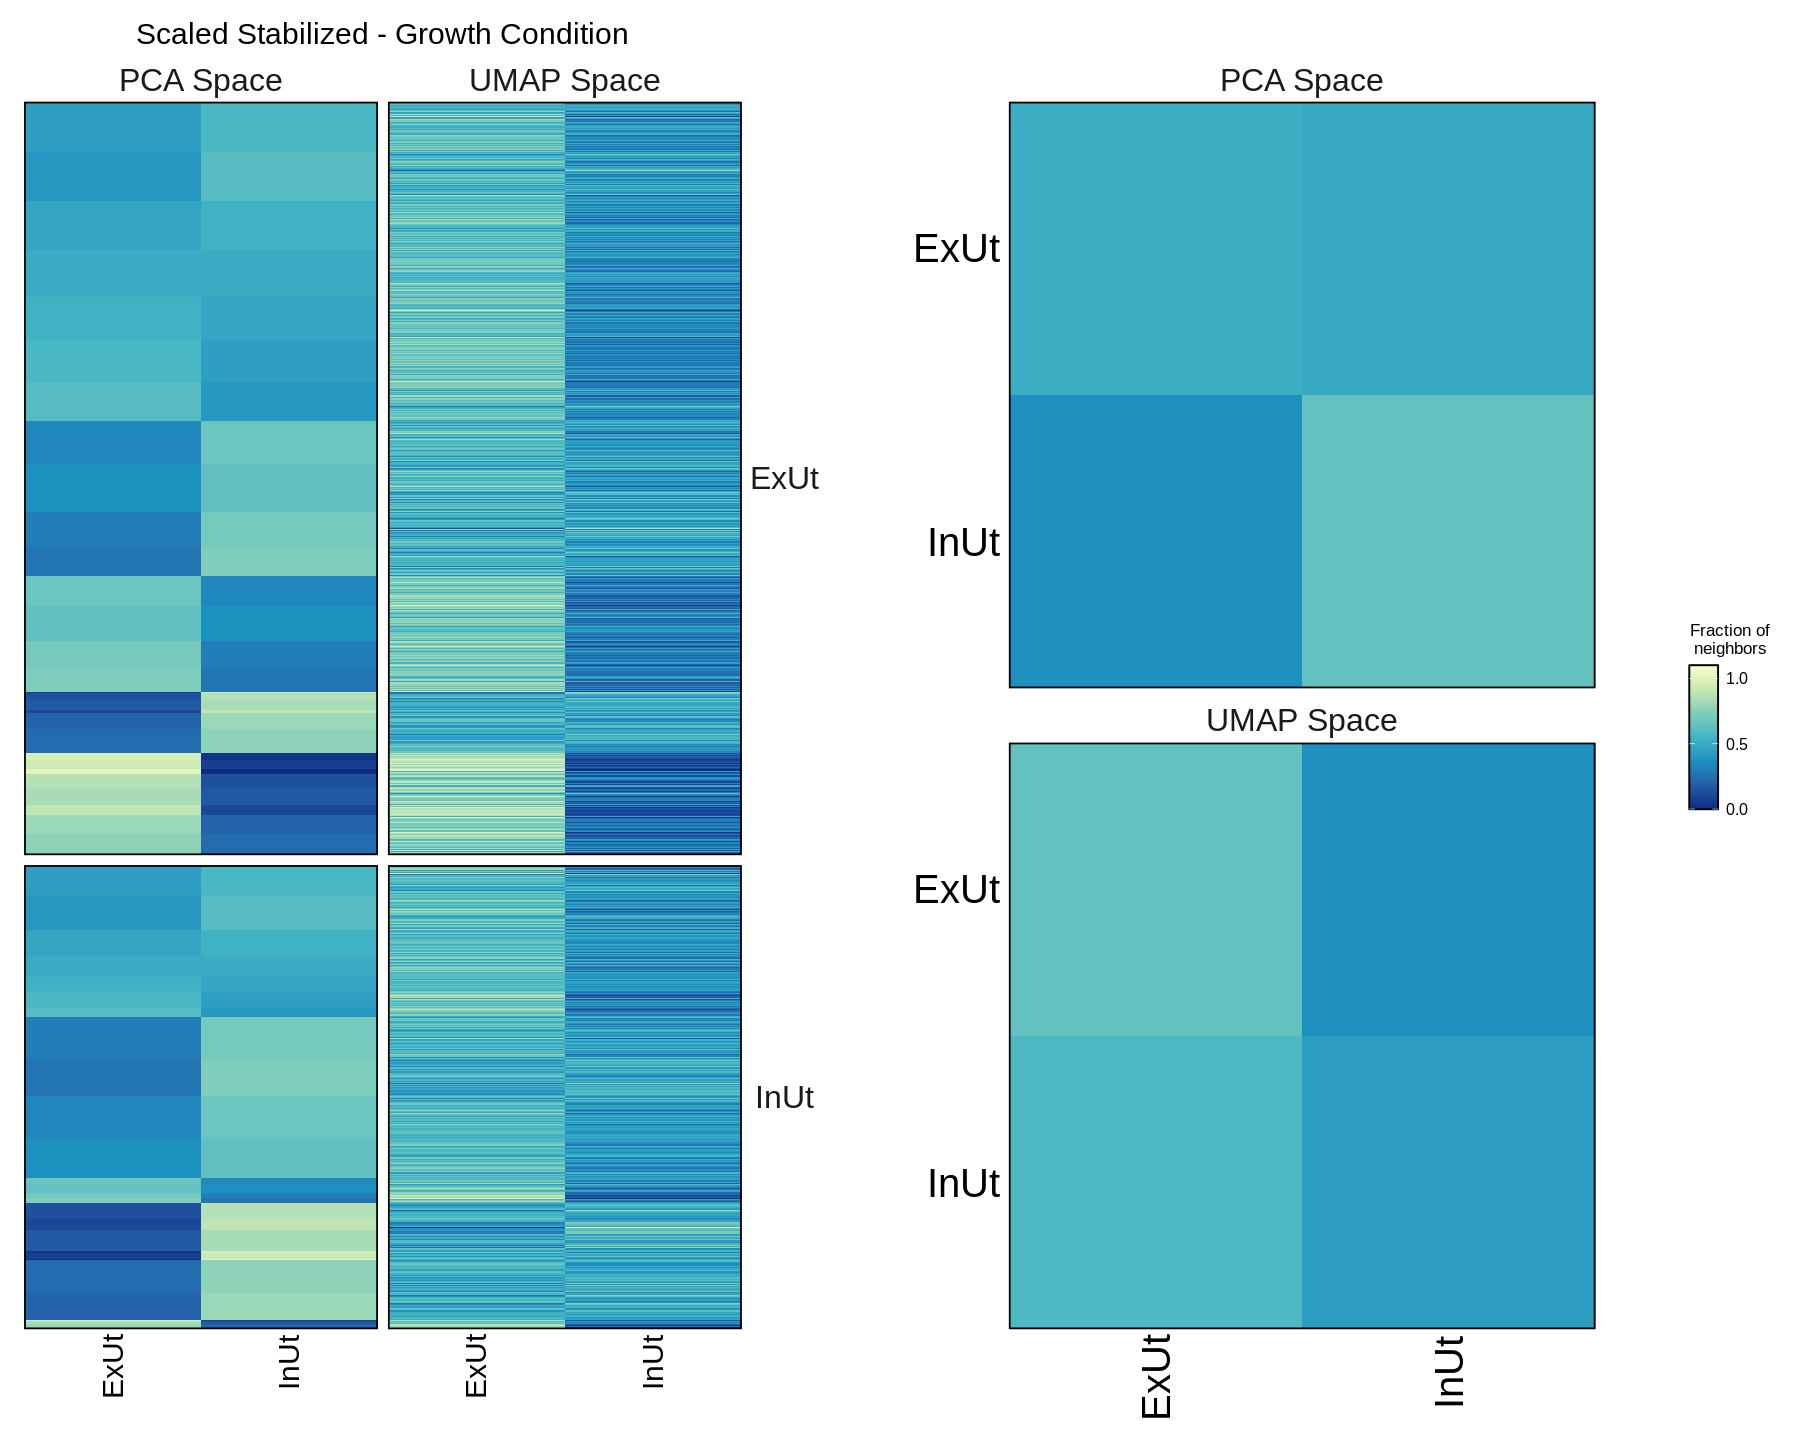

In [ ]:
# options(repr.plot.width = 10, repr.plot.height = 20)

pl_long_hm <- plotManuscriptHeatmap(frac_utero_ss, aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free"))

pl_long_hm <- pl_long_hm +
  labs(title = "Scaled Stabilized - Growth Condition") +
  scale_y_continuous(expand=expansion(add=0)) +
  scale_x_discrete(expand=expansion(add=0)) +
  theme(
  plot.title = element_text(size=rel(1.5)),
  axis.text.y = element_blank(),
  axis.text.x = element_text(size=rel(2)),
  strip.background = element_blank(),
  strip.text.x = element_text(size=rel(2)),
  strip.text.y = element_text(angle=0, size=rel(2))
  )


pl_cdx <- plotManuscriptHeatmap(cdx_map_utero_ss, aes(name, row_label),
  facet_layer=facet_wrap(vars(id), nrow=2))

pl_cdx <- pl_cdx +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
    theme(
    aspect.ratio=1,
    axis.text = element_text(size=rel(2)),
    strip.text.x = element_text(size=rel(2)),)

(pl_long_hm | pl_cdx) + plot_layout(guides='collect')

Same plot as above, except using log normalized data

In [ ]:
cdx_map_utero_log <- bind_rows("PCA Space" = data.frame(cdx_utero_log_pca$map), "UMAP Space" = data.frame(cdx_utero_log_umap$map), .id = 'id')
cdx_map_utero_log <- cdx_map_utero_log %>%
  tibble::rownames_to_column('row_label') %>%
  mutate(
  row_label = str_remove(row_label, "\\.+[0-9]+"),
  row_label = factor(row_label, c("InUt", "ExUt"))) %>%
  pivot_longer(-c("row_label", "id"))

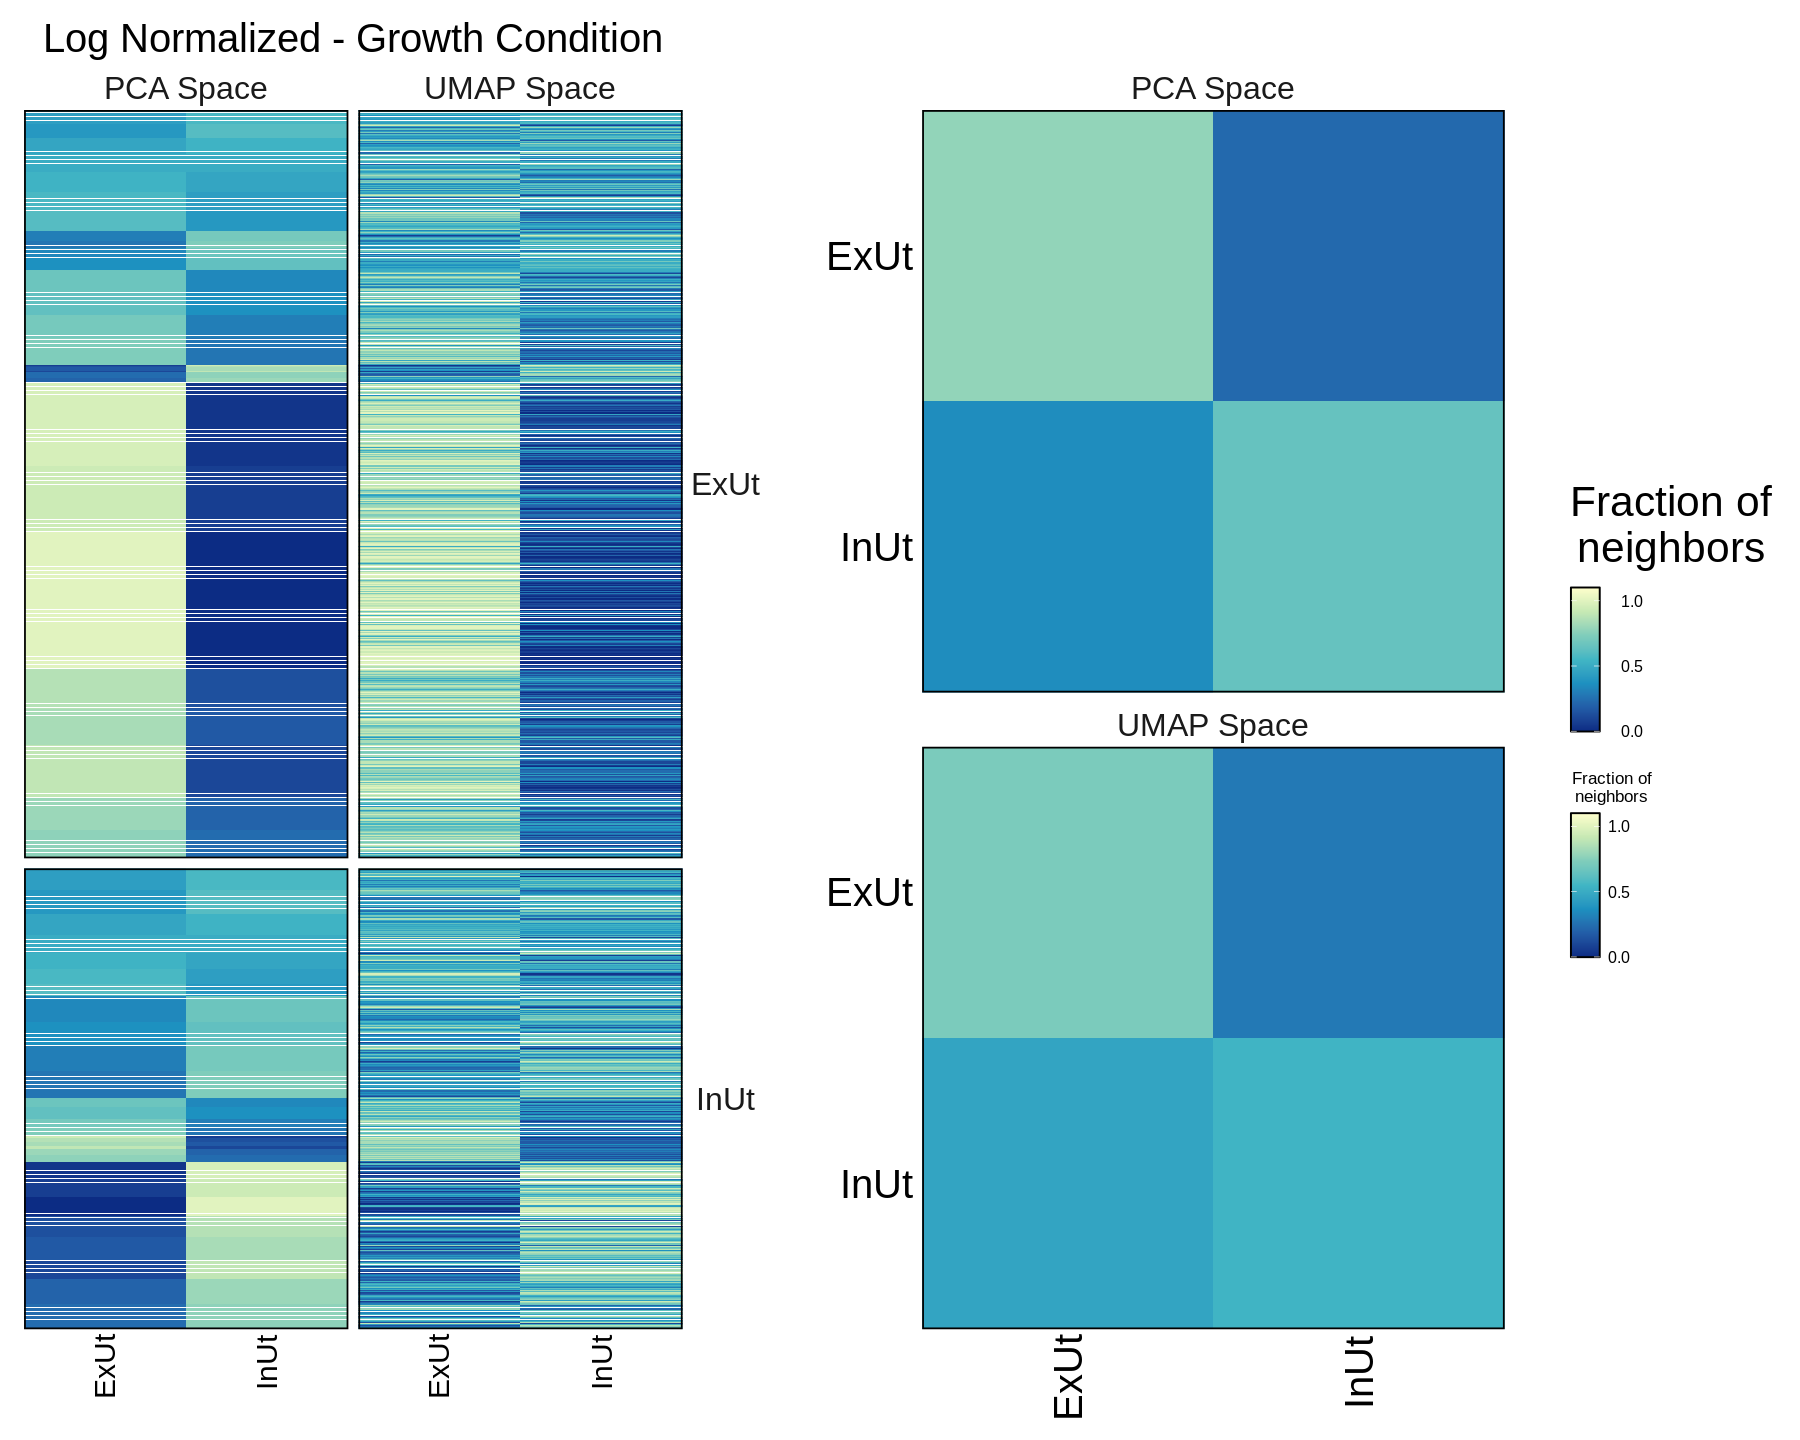

In [ ]:
pl_long_hm <- plotManuscriptHeatmap(frac_utero_log, aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free"))

pl_long_hm <- pl_long_hm +
  labs(title = "Log Normalized - Growth Condition") +
  scale_y_continuous(expand=expansion(add=0)) +
  scale_x_discrete(expand=expansion(add=0)) +
  theme(
  title = element_text(size=rel(2.5)),
  axis.text.y = element_blank(),
  axis.text.x = element_text(size=rel(2)),
  strip.background = element_blank(),
  strip.text.x = element_text(size=rel(2)),
  strip.text.y = element_text(angle=0, size=rel(2))
  )


pl_cdx <- plotManuscriptHeatmap(cdx_map_utero_log, aes(name, row_label),
  facet_layer=facet_wrap(vars(id), nrow=2))

pl_cdx <- pl_cdx +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
    theme(
    aspect.ratio=1,
    axis.text = element_text(size=rel(2)),
    strip.text.x = element_text(size=rel(2)),)

(pl_long_hm | pl_cdx) + plot_layout(guides='collect')

### Cluster Assignment Plots

In [ ]:
cdx_map_clust_ss <- bind_rows("PCA Space" = data.frame(cdx_clust_ss_pca$map), "UMAP Space" = data.frame(cdx_clust_ss_umap$map), .id = 'id')
cdx_map_clust_ss <- cdx_map_clust_ss %>%
  tibble::rownames_to_column('row_label') %>%
  mutate(
    row_label = str_remove(row_label, "\\.+[0-9]+")) %>%
  pivot_longer(-c("id", "row_label")) %>%
  mutate(
    row_label = factor(row_label, rev(cluster_order)),
    name = factor(name, cluster_order)
  )

Separate larger/smaller clusters to see patterns a bit more clearly.

In [ ]:
small_clusts <- paste0("cluster_", 14:19)

pl_sml_clusts <- frac_clust_ss %>%
  filter(group %in% small_clusts) %>%
  mutate(name = factor(name, cluster_order)) %>%
  plotManuscriptHeatmap(aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free", switch="y"))

pl_sml_clusts <- pl_sml_clusts +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_continuous(expand=expansion(add=0)) +
  theme(
    axis.text.y=element_blank(),
    strip.text.y.left=element_text(angle=0))

pl_lrg_clusts <- frac_clust_ss %>%
  filter(!group %in% small_clusts) %>%
  mutate(
    name = factor(name, cluster_order),
    group = factor(group, cluster_order)
  ) %>%
  plotManuscriptHeatmap(aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free", switch="y"))

pl_lrg_clusts <- pl_lrg_clusts +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_continuous(expand=expansion(add=0)) +
  theme(
    axis.text.y=element_blank(),
    strip.text.y.left=element_text(angle=0))

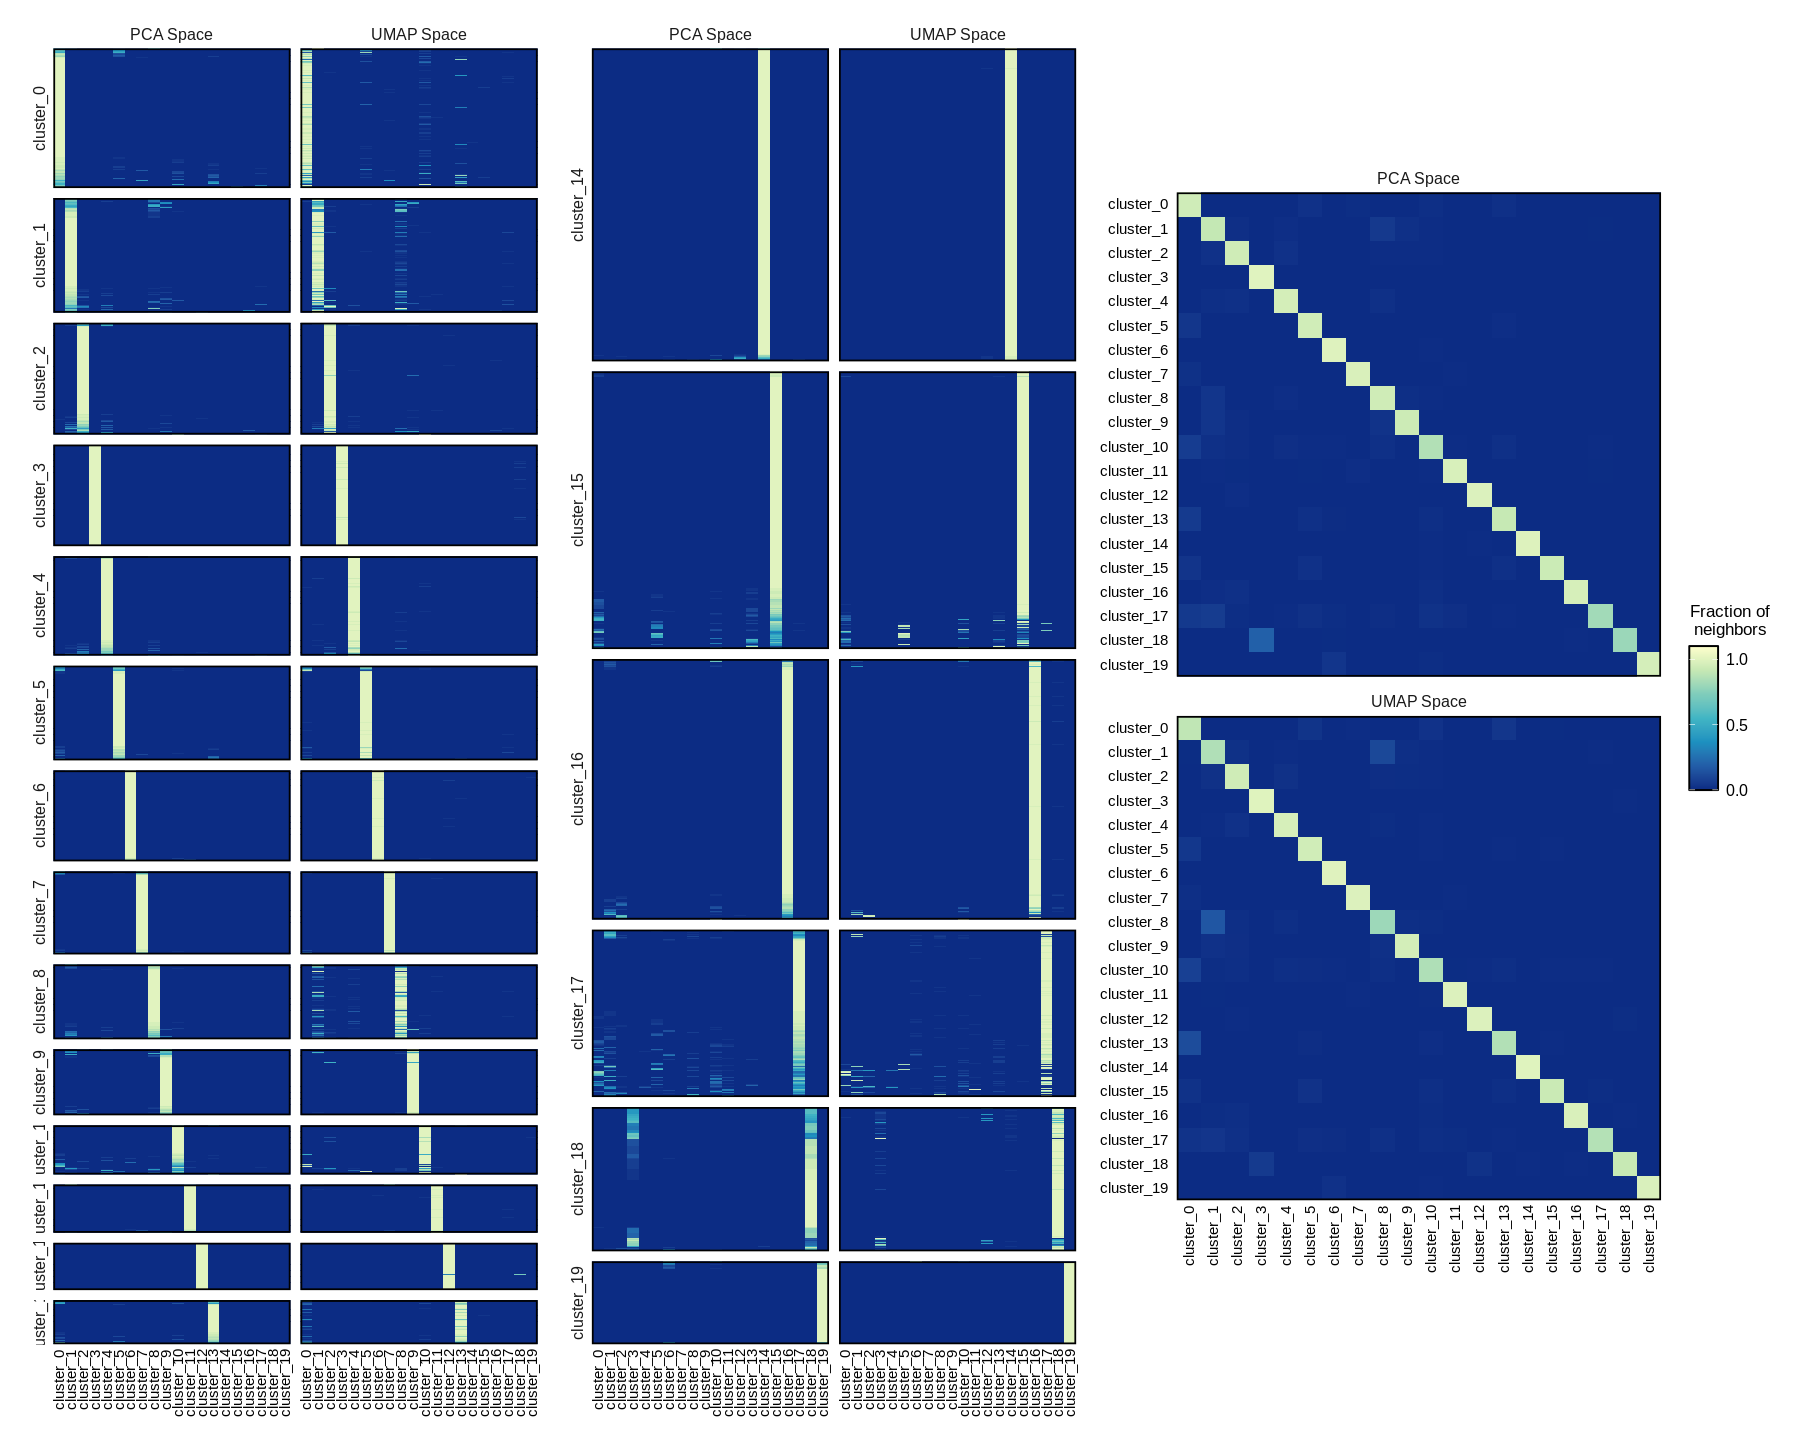

In [ ]:
pl_cdx <- plotManuscriptHeatmap(cdx_map_clust_ss, aes(name, row_label),
  facet_layer=facet_wrap(vars(id), nrow=2))

pl_cdx <- pl_cdx +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
    theme(aspect.ratio=1)

(pl_lrg_clusts| pl_sml_clusts| pl_cdx) + plot_layout(guides="collect")

Same plots as above, but for log normalized data.

In [ ]:
cdx_map_clust_log <- bind_rows("PCA Space" = data.frame(cdx_clust_log_pca$map), "UMAP Space" = data.frame(cdx_clust_log_umap$map), .id = 'id')
cdx_map_clust_log <- cdx_map_clust_log %>%
  tibble::rownames_to_column('row_label') %>%
  mutate(
    row_label = str_remove(row_label, "\\.+[0-9]+")) %>%
  pivot_longer(-c("id", "row_label")) %>%
  mutate(
    row_label = factor(row_label, rev(cluster_order)),
    name = factor(name, cluster_order)
  )

In [ ]:
pl_sml_clusts <- frac_clust_log %>%
  filter(group %in% small_clusts) %>%
  mutate(name = factor(name, cluster_order)) %>%
  plotManuscriptHeatmap(aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free", switch="y"))

pl_sml_clusts <- pl_sml_clusts +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_continuous(expand=expansion(add=0)) +
  theme(
    axis.text.y=element_blank(),
    strip.text.y.left=element_text(angle=0))

pl_lrg_clusts <- frac_clust_log %>%
  filter(!group %in% small_clusts) %>%
  mutate(
    name = factor(name, cluster_order),
    group = factor(group, cluster_order)
  ) %>%
  plotManuscriptHeatmap(aes(name, within_row_order),
  facet_layer=facet_grid(vars(group), vars(id), scales = "free_y", space = "free", switch="y"))

pl_lrg_clusts <- pl_lrg_clusts +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_continuous(expand=expansion(add=0)) +
  theme(
    axis.text.y=element_blank(),
    strip.text.y.left=element_text(angle=0))

In [ ]:
pl_cdx <- plotManuscriptHeatmap(cdx_map_clust_log, aes(name, row_label),
  facet_layer=facet_wrap(vars(id), nrow=2))

pl_cdx <- pl_cdx +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
    theme(aspect.ratio=1)

(pl_lrg_clusts| pl_sml_clusts| pl_cdx) + plot_layout(guides="collect")

## Supplementary Figure 2

The k-nearest neighbor matrices for the ambient data are derived from the Colab notebook linked [here](https://github.com/pachterlab/CP_2023/blob/main/notebooks/uteroMixingAnalysis/uteroAnalysis_l2.ipynb). Here, and in the linked notebook, the input matrices have been mean centered and scaled.

In [ ]:
knn_ss_amb  <- readMM(path(data_dir,"knn-ss-amb.mtx.gz"))
knn_ss_amb  <- as(knn_ss_amb, "CsparseMatrix")


knn_log_amb  <- readMM(path(data_dir,"knn-log-amb.mtx.gz"))
knn_log_amb  <- as(knn_log_amb, "CsparseMatrix")

In [ ]:
cdx_utero_log_amb <- calculateConcordex(knn_log_amb, meta$utero, k=30)
cdx_utero_ss_amb <- calculateConcordex(knn_ss_amb, meta$utero, k=30)

In [ ]:
# Add ambient results to PCA and UMAP results
cdx_map_utero_log <- data.frame(cdx_utero_log_amb$map,
   id="Ambient Space", row_label=rownames(cdx_utero_log_amb$map)) %>%
pivot_longer(-c(id,row_label)) %>%
bind_rows(cdx_map_utero_log)

cdx_map_utero_ss <- data.frame(cdx_utero_ss_amb$map,
   id="Ambient Space", row_label=rownames(cdx_utero_ss_amb$map)) %>%
pivot_longer(-c(id,row_label)) %>%
bind_rows(cdx_map_utero_ss)

Stabilized, scaled data

In [ ]:
plotManuscriptHeatmap(cdx_map_utero_ss, aes(name, row_label), facet_layer = facet_wrap(vars(id), nrow=1)) +
  geom_label(aes(label=round(value,2))) +
  labs(title = "Stabilized-Scaled") +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
  theme(aspect.ratio = 1)

Log Normalized Data

In [ ]:
plotManuscriptHeatmap(cdx_map_utero_log, aes(name, row_label), facet_layer = facet_wrap(vars(id), nrow=1)) +
  geom_label(aes(label=round(value,2))) +
  labs(title = "Log Normalized") +
  scale_x_discrete(expand=expansion(add=0)) +
  scale_y_discrete(expand=expansion(add=0)) +
  theme(aspect.ratio = 1)

## Supplementary Figure 3

Mixed neighborhoods analysis

In [ ]:
mixed_ss <- frac_clust_ss %>%
  group_by(id, row_original) %>%
  filter(group == name) %>%
  mutate(mixed = ifelse(value > 0.5, FALSE, TRUE)) %>%
  ungroup() %>%
  group_by(id, group) %>%
  summarise(n_mixed_neigh = sum(mixed)) %>%
  ungroup() %>%
  arrange(group)

mixed_log <- frac_clust_log %>%
  group_by(id, row_original) %>%
  filter(group == name) %>%
  mutate(mixed = ifelse(value > 0.5, FALSE, TRUE)) %>%
  ungroup() %>%
  group_by(id, group) %>%
  summarise(n_mixed_neigh = sum(mixed)) %>%
  ungroup() %>%
  arrange(group)

mixed_df <- bind_rows(list("Stabilized, Scaled" = mixed_ss, "Log Normalized" = mixed_log), .id="norm_method")


In [ ]:
options(repr.plot.width = 15, repr.plot.height = 12)

mixed_df %>%
  pivot_wider(
    names_from=id,
    values_from=n_mixed_neigh,
    names_repair='universal') %>%
  ggplot(aes(PCA.Space, UMAP.Space, color=group)) +
  geom_point() +
  geom_abline(slope=1, intercept=0, color="red") +
  labs(
    x = "# cells with mixed neighborhoods in PCA Space",
    y = "# cells with mixed neighborhoods in UMAP Space") +
  scale_color_manual(values=cluster_colors) +
  facet_wrap(~norm_method) +
  theme_bw() +
  theme(
    aspect.ratio = 1/1.15,
    axis.text=element_text(size=rel(2)),
    axis.title=element_text(size=rel(2)),
    strip.text=element_text(size=rel(2))
    )

## Supplementary Figure 4

To be consistent with the PCA results and UMAP algorithm that generated Figure 3, we again used the output generated from the notebook linked [here](https://github.com/pachterlab/CP_2023/blob/main/notebooks/uteroMixingAnalysis/uteroAnalysis_l2.ipynb). The parameters to the UMAP algorithm were changed as indicated in the figure and table.

In [ ]:
# Read in UMAP output
umap_coords_new <- vroom(path(data_dir, "umap-coords-new.csv.gz"))

### Compute CONCORDEX for each combination of parameters

In [18]:
# Compute concordex for each set of parameters
cdx_cluster_new <- umap_coords_new %>%
    mutate(id = paste(params, norm_method, sep="_")) %>%
    split(.$id) %>%
    map(\(x){
        knn <- findKNN(as(x[,1:2],'Matrix'), k=30)
        # knn <- expand_knn_list(knn$index)

        cdx <- calculateConcordex(knn$index, meta$cluster, k=30)
        cdx
    })

cdx_cluster_new_val <- map(cdx_cluster_new, \(x) c(x[1:3]))
cdx_cluster_new_val <- bind_rows(cdx_cluster_new_val, .id='source')
cdx_cluster_new_val <- cdx_cluster_new_val %>%
    mutate(
        norm_method = str_extract(source, "ss|log"),
        space = "umap", label = "cluster")

cdx_cluster_new_map <- map(cdx_cluster_new, \(x) data.frame(x$map, cdx = x$concordex))
cdx_cluster_new_map <- bind_rows(cdx_cluster_new_map, .id='source') %>%
    mutate(label = 'cluster')

cdx_cluster_new_map <- cdx_cluster_new_map %>%
    rownames_to_column(var = 'row_label') %>%
    mutate(row_label = str_extract(row_label, "cluster_[0-9]+"))

cdx_cluster_new_map <- cdx_cluster_new_map %>%
    pivot_longer(cols = starts_with("cluster")) %>%
    mutate(id = "UMAP Space",
        norm_method = str_extract(source, "ss|log"),
        source = str_remove(source, "_(ss|log)"))

In [19]:
cdx_batch_new <- umap_coords_new %>%
    mutate(id = paste(params, norm_method, sep="_")) %>%
    split(.$id) %>%
    map(\(x){
        knn <- findKNN(as(x[,1:2],'Matrix'), k=30)

        cdx <- calculateConcordex(knn$index, meta$utero, k=30)
        cdx
    })

cdx_batch_new_val <- map(cdx_batch_new, \(x) c(x[1:3]))
cdx_batch_new_val <- bind_rows(cdx_batch_new_val, .id='source')
cdx_batch_new_val <- cdx_batch_new_val %>%
    mutate(
        norm_method = str_extract(source, "ss|log"),
        space = "umap", label = "batch")

# Get the map objects from concordex output
cdx_batch_new_map <- map(cdx_batch_new, \(x) data.frame(x$map, cdx = x$concordex))
cdx_batch_new_map <- bind_rows(cdx_batch_new_map, .id='source') %>%
    mutate(label = 'batch')

cdx_batch_new_map <- cdx_batch_new_map %>%
    rownames_to_column(var = 'row_label') %>%
    mutate(row_label = str_extract(row_label, "(Ex|In)Ut"))

cdx_batch_new_map <- cdx_batch_new_map %>%
    pivot_longer(cols = contains("Ut")) %>%
    mutate(id = "UMAP Space",
           norm_method = str_extract(source, "ss|log"),
           source = str_remove(source, "_(ss|log)"))

In [ ]:
# combine into a single data frame
cdx_map_all_new <- bind_rows(cdx_cluster_new_map, cdx_batch_new_map) %>%
    separate_wider_delim(source, "_",
                         names=c("k", "state","min_dist"),
                         cols_remove = FALSE,
                         too_many="drop") %>%
    readr::type_convert(guess_integer=TRUE)

cdx_map_all_new <- cdx_map_all_new %>%
  mutate(
      cdx_lab = glue("concordex = {round(cdx, 2)}"),
      source = paste(source, norm_method,sep="_")
  )

### Plots


In [104]:
# Function for labelling plots
label_fun <- function(labels){
    labels <- label_value(labels)
    pattern <- "([0-9]+)\\_([0-9]+)_([0-9\\.]+)_(ss|log)"

    lapply(labels, function(value) {
        str_replace(value, pattern, "k = \\1, state = \\2, min_dist = \\3")
    })
}

# Set soem plotting options
cdx_batch_hm_fmt <- list(
    guides(fill="none"),
    scale_x_discrete(expand=expansion(),labels=c("Ex Utero","In Utero")),
    scale_y_discrete(expand=expansion(),labels=c("In Utero","Ex Utero")),
    theme(aspect.ratio = 1/1.2)
)

In [105]:
# Concordex cluster heatmap
pl_clust_map <- cdx_map_all_new %>%
    filter(label=='cluster') %>%
    mutate(
        row_label = factor(row_label, rev(cluster_order)),
        name = factor(name, cluster_order)) %>%
    split(.$source) %>%
    map(\(data){
        cdx <- unique(data$cdx)
        plotManuscriptHeatmap(data, aes(name, row_label, fill=value),
          facet_layer=facet_wrap(vars(cdx_lab), nrow=2)
        )+
        guides(fill="none") +
        scale_x_discrete(
          expand=expansion(add=0),
          labels=~str_to_title(str_replace(., "_"," "))) +
        scale_y_discrete(
          expand=expansion(add=0),
          labels=~str_to_title(str_replace(., "_"," ")))
    })

# Concordex growth condition heatmap
pl_batch_map <- cdx_map_all_new %>%
    filter(label=='batch') %>%
    mutate(row_label = factor(row_label, c("InUt", "ExUt")),
           name = factor(name, c("ExUt", "InUt"))) %>%
    split(.$source) %>%
    map(\(data){
        plotManuscriptHeatmap(data, aes(name, row_label),
        facet_layer=facet_wrap(vars(cdx_lab), nrow=2))+
        guides(fill="none") +
        cdx_batch_hm_fmt
    })

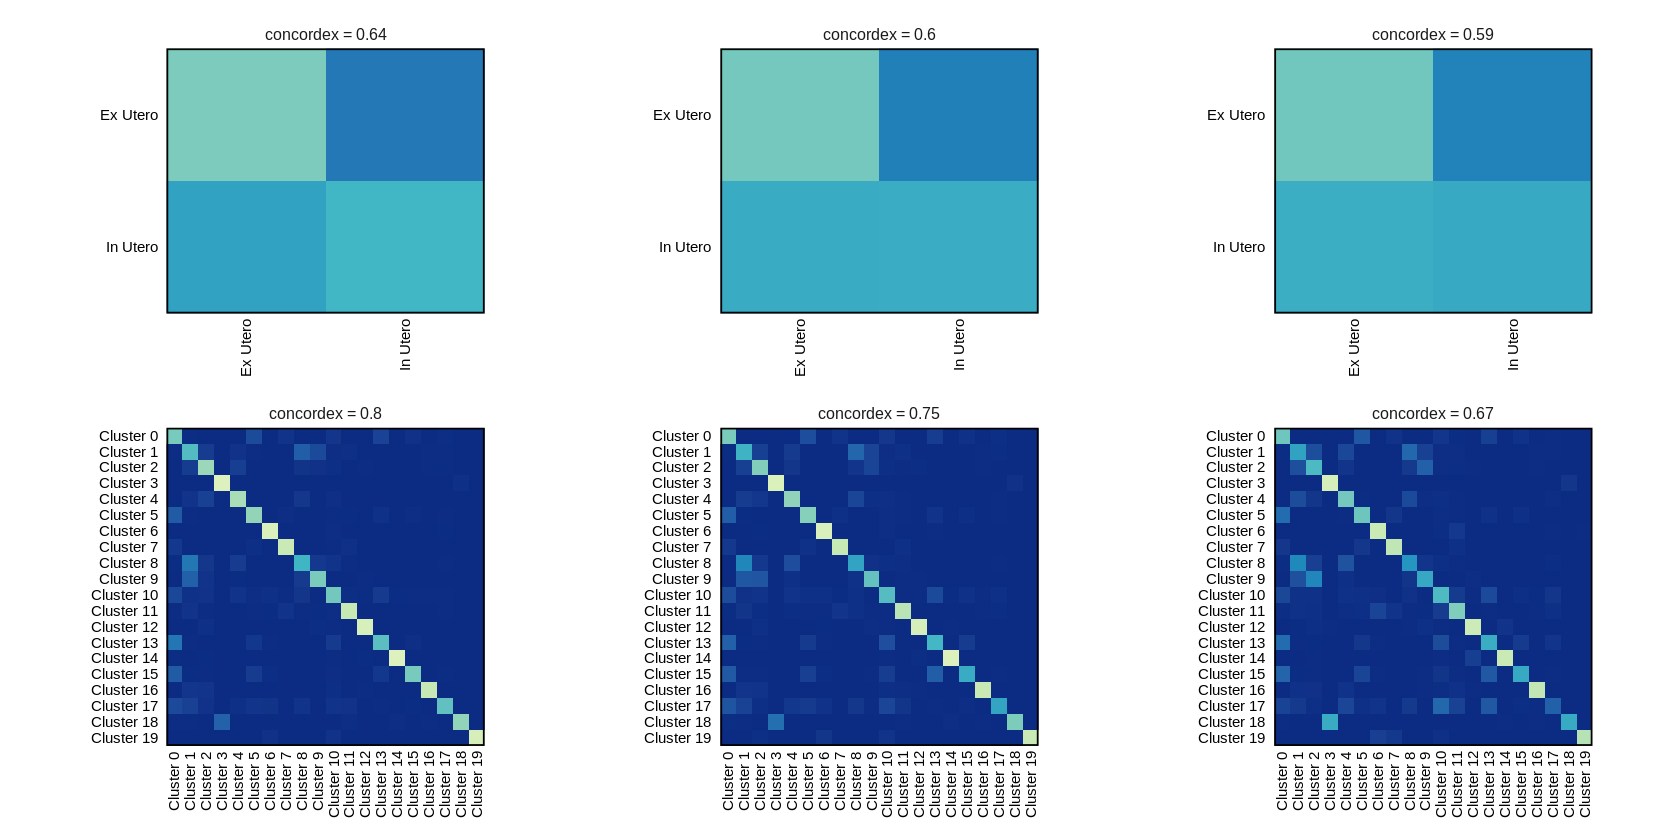

In [117]:
options(repr.plot.width = 14, repr.plot.height = 7)

p1 <- (pl_batch_map[["20_39010_0.1_log"]] / pl_clust_map[["20_39010_0.1_log"]]) +
  plot_annotation(title = label_fun("20_39010_0.1_log"))

p2 <- (pl_batch_map[["20_42_0.5_log"]] / pl_clust_map[["20_42_0.5_log"]]) +
  plot_annotation(title = label_fun("20_42_0.5_log"))
p3 <- (pl_batch_map[["30_39010_0.99_log"]] / pl_clust_map[["30_39010_0.99_log"]]) +
  plot_annotation(title = label_fun("30_39010_0.99_log"))

(p1 | p2 | p3) #+ plot_annotation(title = "Log Normalized")

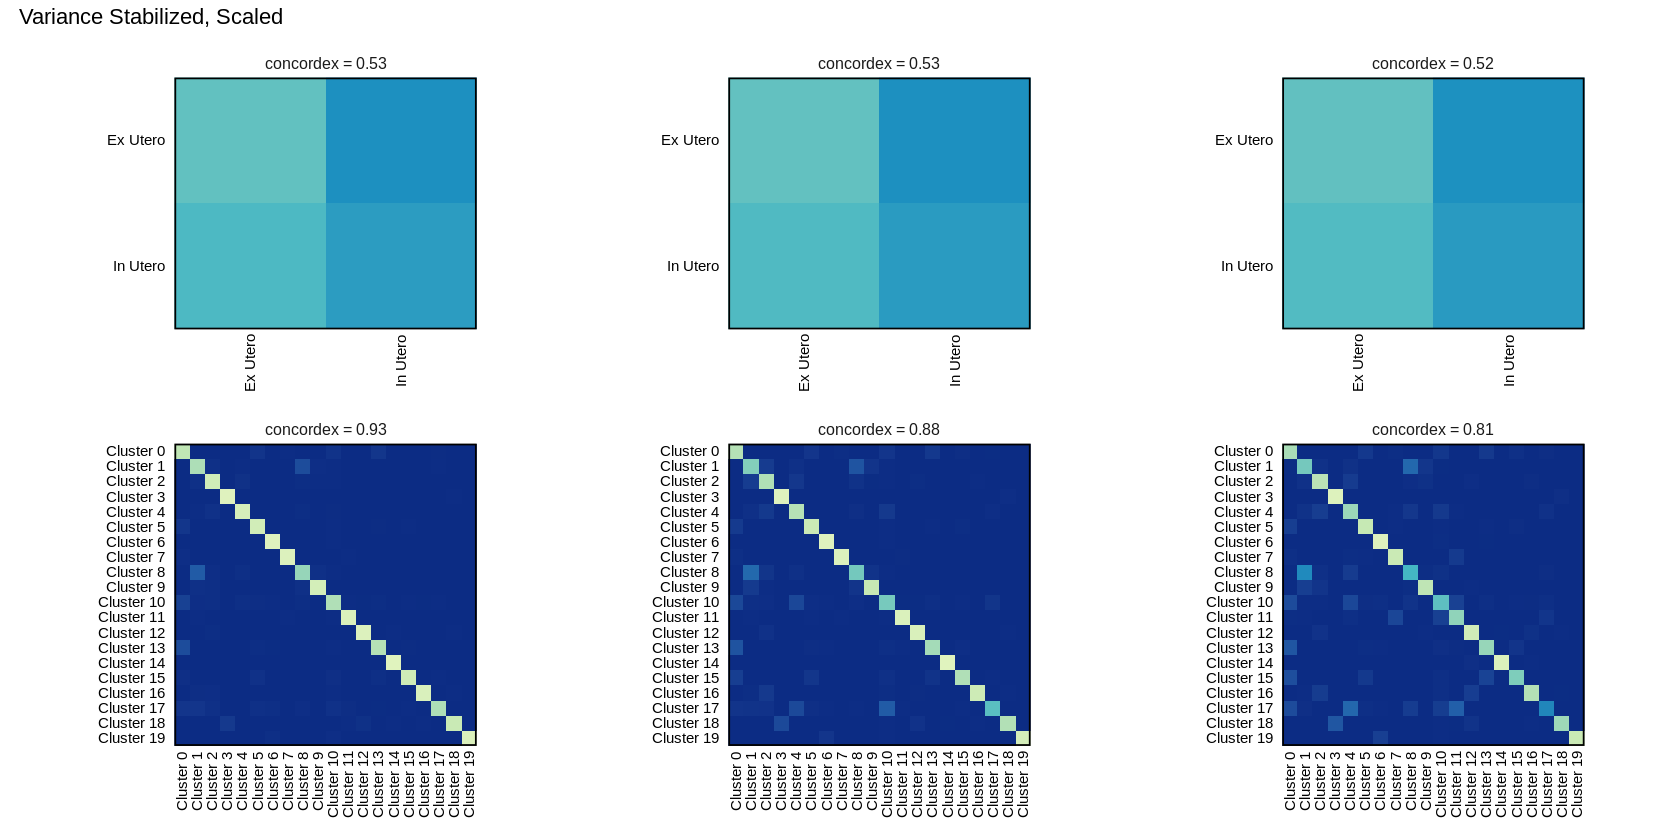

In [112]:
options(repr.plot.width = 14, repr.plot.height = 7)

p1 <- pl_batch_map[["20_39010_0.1_ss"]] / pl_clust_map[["20_39010_0.1_ss"]]
p2 <- pl_batch_map[["30_39010_0.5_ss"]] / pl_clust_map[["30_39010_0.5_ss"]]
p3 <- pl_batch_map[["30_39010_0.99_ss"]] / pl_clust_map[["30_39010_0.99_ss"]]

(p1 | p2 | p3) + plot_annotation(title = "Variance Stabilized, Scaled")